### Step 1: Interpolation

The average diameter is 108.46 pixels or 17.35 microns


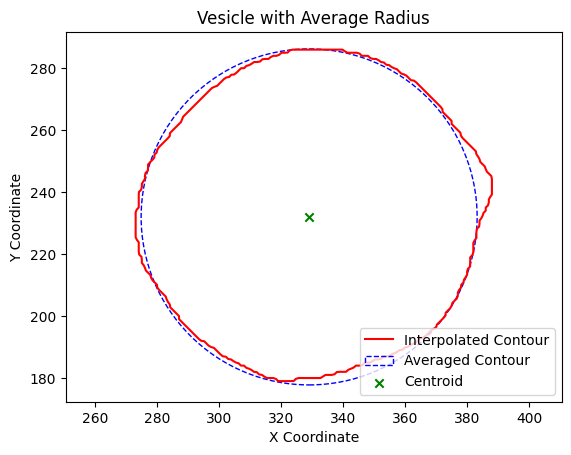

In [13]:
import json
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt

with open('Caski17_log.json', 'r') as file:
    data = json.load(file)
    
def interpolate_coordinates(coords, num_points=360):
    coords_array = np.array(coords + [coords[0]])  # Append first point to end to close the loop
    distances = np.sqrt(np.sum(np.diff(coords_array, axis=0)**2, axis=1))
    cumulative_distances = np.insert(np.cumsum(distances), 0, 0)
    interpolated_distances = np.linspace(0, cumulative_distances[-1], num_points)
    interp_func_x = interp1d(cumulative_distances, coords_array[:,0], kind='linear')
    interp_func_y = interp1d(cumulative_distances, coords_array[:,1], kind='linear')
    interpolated_x = interp_func_x(interpolated_distances)
    interpolated_y = interp_func_y(interpolated_distances)
    return np.column_stack((interpolated_x, interpolated_y))

def calculate_radius(centroid, coords):
    return [euclidean(centroid, point) for point in coords]

all_radii = []
for frame in data:
    interpolated_coords = interpolate_coordinates(frame['circumference_coordinates'])
    centroid = frame['centroid']
    radii = calculate_radius(centroid, interpolated_coords)
    all_radii.append(np.mean(radii))
global_average_radius = np.mean(all_radii)

print('The average diameter is '
      + '{0:.2f}'.format(global_average_radius*2) 
      + ' pixels or ' 
      + '{0:.2f}'.format(global_average_radius*2*0.16) + ' microns')

first_frame = data[0]
centroid = first_frame['centroid']
interpolated_coords = interpolate_coordinates(first_frame['circumference_coordinates'])
plt.figure()
plt.plot(interpolated_coords[:, 0], interpolated_coords[:, 1], 'r-', label='Interpolated Contour')
circle = plt.Circle((centroid[0], centroid[1]), global_average_radius, color='b', fill=False, linestyle='--', label='Averaged Contour')
plt.gca().add_patch(circle)
plt.scatter(centroid[0], centroid[1], color='g', marker='x', label='Centroid')
plt.title('Vesicle with Average Radius')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.legend(loc='lower right', bbox_to_anchor=(1, 0), facecolor='white')
plt.axis('equal')
plt.show()


### Step 2: Polar Coordinates

In [14]:
def convert_to_polar(centroid, coords):
    x_offset = coords[:, 0] - centroid[0]
    y_offset = coords[:, 1] - centroid[1]
    radius = np.sqrt(x_offset**2 + y_offset**2)
    angle = np.arctan2(y_offset, x_offset)
    return radius, angle

all_polar_coords = {}
for frame in data:
    interpolated_coords = interpolate_coordinates(frame['circumference_coordinates'])  # Interpolate per frame
    centroid = frame['centroid']
    radius, angle = convert_to_polar(centroid, interpolated_coords)
    all_polar_coords[frame['frame_number']] = {'radius': radius, 'angle': angle}

for frame_number in list(all_polar_coords.keys())[:2]:  # Print details for the first several frames
    frame_data = all_polar_coords[frame_number]
    print(f"Frame {frame_number}:")
    print("Number of angles: ", len(frame_data['angle']))
    print("Number of radii: ", len(frame_data['radius']))
    print("Sample angles: ", frame_data['angle'][:5])
    print("Sample radii: ", frame_data['radius'][:5]) 
    print()
    


Frame 1:
Number of angles:  360
Number of radii:  360
Sample angles:  [-1.75728323 -1.77286222 -1.79026458 -1.80862891 -1.82683119]
Sample radii:  [53.93514624 53.37410441 53.27795954 53.50615033 53.75222925]

Frame 2:
Number of angles:  360
Number of radii:  360
Sample angles:  [-1.81133057 -1.82739885 -1.84481851 -1.8628243  -1.87987873]
Sample radii:  [54.5710546  54.0516807  54.01529661 54.298907   54.10576256]


### Step 3: Equatorial Contour Correlation Function 

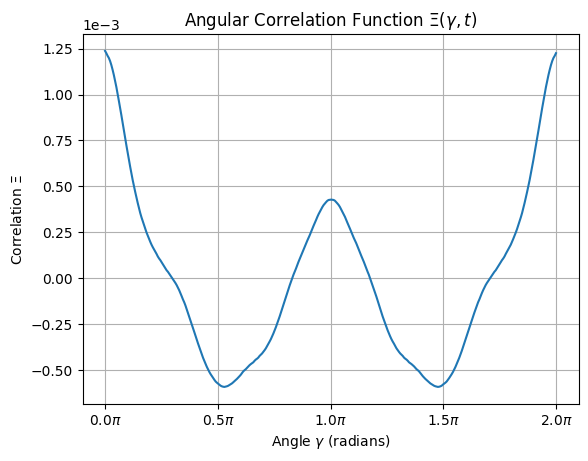

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def angular_correlation(radius, average_radius, num_points=360):
    gamma_values = np.linspace(0, 2 * np.pi, num_points)
    Xi = np.zeros(num_points)
    delta_phi = 2 * np.pi / num_points

    for i in range(num_points):
        correlation_sum = 0
        for j in range(num_points):
            gamma_index = (j + i) % num_points  # Wrapping index
            correlation = (radius[gamma_index] * radius[j]) - (average_radius**2)
            correlation_sum += correlation

        Xi[i] = (1 / (average_radius**2)) * (1 / (2 * np.pi)) * correlation_sum * delta_phi

    return Xi

num_frames = len(data)  
Xi_matrix = np.zeros((num_frames, 360))  # 360 should match the number of points used in angular_correlation
average_radii = [np.mean(frame['radius']) for frame in all_polar_coords.values()]

# Populate the Xi matrix for each frame
for t, frame in enumerate(all_polar_coords.values()):
    radius = frame['radius']
    average_radius = average_radii[t]
    Xi_matrix[t] = angular_correlation(radius, average_radius)
    
# Convert x-axis ticks from degrees to radians
degree_ticks = np.linspace(0, 360, num=5)
radian_ticks = np.deg2rad(degree_ticks)
radian_labels = ['0', '$\pi/2$', '$\pi$', '$3\pi/2$', '$2\pi$']

# Plotting
fig, ax = plt.subplots()
ax.plot(np.linspace(0, 2*np.pi, num=360), Xi_matrix[0])
ax.set_xlabel('Angle $\gamma$ (radians)')
ax.set_ylabel('Correlation $\Xi$')
ax.set_title('Angular Correlation Function $\Xi(\gamma, t)$')

# Setting x-axis to display pi notation
ax.xaxis.set_major_locator(ticker.MultipleLocator(base=np.pi / 2))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda val, pos: f'{val / np.pi:.1f}$\pi$'))

# Setting y-axis to scientific notation
ax.ticklabel_format(style='sci', axis='y', scilimits=(0,0))

plt.grid(True)
plt.show()


### Step 4: Mode Analysis of Spatial Correlations

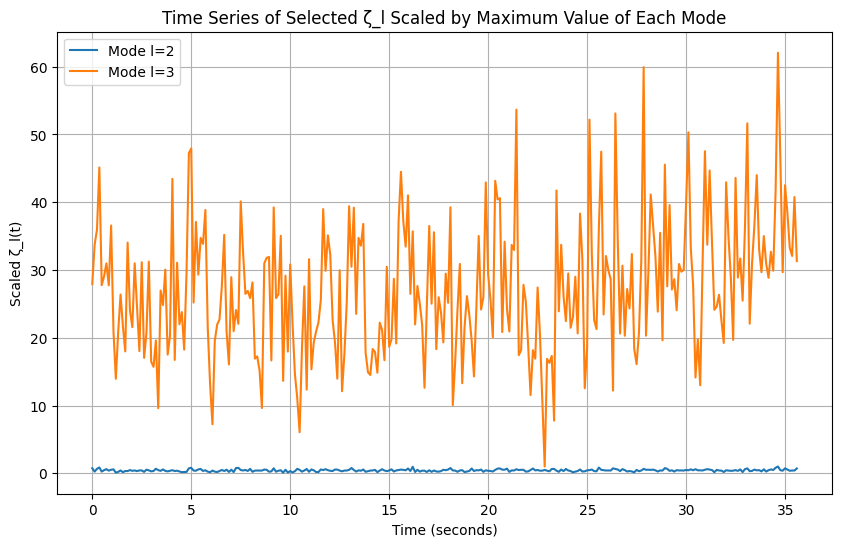

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.special import sph_harm, legendre
from scipy.integrate import simpson

# Initialize simulation parameters
num_frames = 300
exposure_time = 0.009
delay_between_frames = 0.11
total_time_per_frame = exposure_time + delay_between_frames

# Spherical Harmonic Decomposition
max_degree = 3  # Maximum degree of spherical harmonics
harmonic_coeffs = np.zeros((num_frames, max_degree + 1, 2 * max_degree + 1), dtype=complex)

# Calculate the spherical harmonic coefficients
for t, frame in enumerate(all_polar_coords.values()):
    radius = frame['radius']
    phi_values = np.linspace(0, 2 * np.pi, len(radius))
    for l in range(max_degree + 1):
        for m in range(-l, l + 1):
            sum_coeffs = 0
            for phi, r in zip(phi_values, radius):
                theta = np.pi / 2  # assuming theta from the literature (pi/2)
                sum_coeffs += r * np.conj(sph_harm(m, l, phi, theta))
            harmonic_coeffs[t, l, m + max_degree] = sum_coeffs

# Legendre Polynomial Transform using scipy.special.legendre
zeta_l_t = np.zeros((num_frames, max_degree + 1))
cos_gamma = np.linspace(-1, 1, 360)
for t in range(num_frames):
    for l in range(2, max_degree + 1):  # Starting from l=2 as per theory
        P_l = legendre(l)  # Get the Legendre polynomial object of degree l
        zeta_l_t[t, l] = (2 * l + 1) / 2 * simpson(y=Xi_matrix[t] * P_l(cos_gamma), x=cos_gamma)

# Compute the mean <zeta_l>
mean_zeta_l = np.zeros(max_degree + 1)
for l in range(2, max_degree + 1):
    mean_zeta_l[l] = (2 * l + 1) / (4 * np.pi) * np.mean(np.abs(harmonic_coeffs[:, l, max_degree])**2)

# Compute the time axis for plotting
time_axis = np.arange(num_frames) * total_time_per_frame

# Normalize zeta_l_t by the maximum value for each mode
epsilon = 1e-10  # A small number to prevent division by zero
max_zeta_l = np.max(zeta_l_t, axis=0)
scaled_zeta_l_t = zeta_l_t / (max_zeta_l + epsilon)  # Add epsilon to the denominator

# Plotting for selected modes
selected_modes = [2, 3, 6, 9]
plt.figure(figsize=(10, 6))
for l in selected_modes:
    if l <= max_degree:  # Ensure mode is within the computed range
        plt.plot(time_axis, scaled_zeta_l_t[:, l], label=f'Mode l={l}')

plt.xlabel('Time (seconds)')
plt.ylabel('Scaled ζ_l(t)')
plt.title('Time Series of Selected ζ_l Scaled by Maximum Value of Each Mode')
plt.legend()
plt.grid(True)
plt.show()
